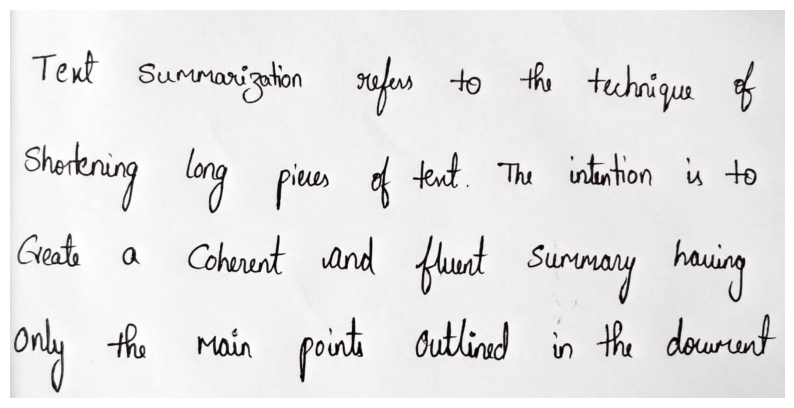

In [1]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import cv2

# read the image, check if its 3 channel or grayscale, based on 
# that convert to grayscale
img = cv2.imread("images/handwritten.jpg")

plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show() # preview

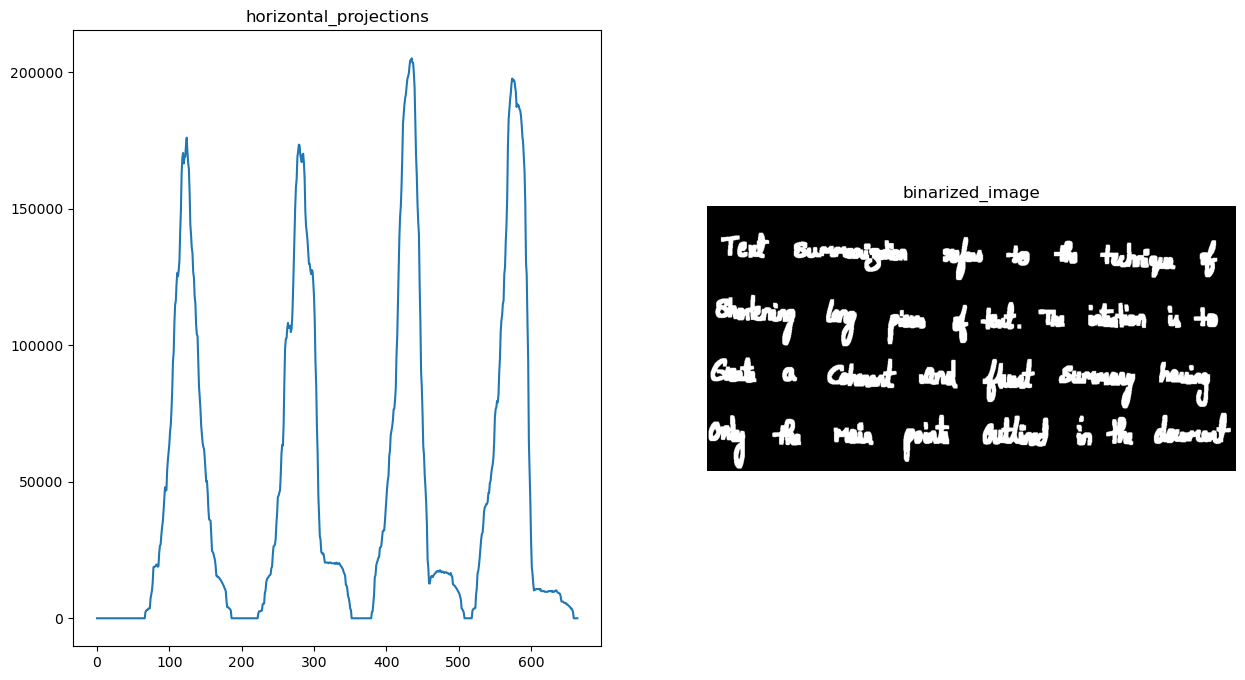

In [2]:
from skimage.filters import threshold_otsu
import numpy as np

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)  

def sauvola_thresholding(image, window_size=25, k=0.4, R=128):
    # Convert image to float
    image = image.astype(np.float64)
    # Calculate the mean and standard deviation for each window
    mean = cv2.boxFilter(image, cv2.CV_64F, (window_size, window_size))
    sq_mean = cv2.boxFilter(image**2, cv2.CV_64F, (window_size, window_size))
    variance = sq_mean - mean**2
    stddev = np.sqrt(variance)
    # Calculate Sauvola threshold
    threshold = mean * (1 + k * ((stddev / R) - 1))
    # Apply threshold to binarize the image
    binary_image = (image > threshold).astype(np.uint8) * 255
    return 255-binary_image

def edges_detect(img_gray):
    img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)
    # Sobel Edge Detection   
    sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)
    sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)
    sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=3)
    edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200)
    return edges

    
# check if its 3 channel or grayscale, based on that convert to grayscale
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
original_img=img.copy()
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#remove the noise
blurred_image = cv2.GaussianBlur(img, (3, 3), 0)
edges = edges_detect(blurred_image)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
dilated_image = cv2.dilate(edges, kernel, iterations=1)

# Apply Sauvola thresholding
binary_image = sauvola_thresholding(dilated_image)
_, binary_image = cv2.threshold(binary_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)   
hpp = horizontal_projections(binary_image)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.set_title("horizontal_projections")
ax1.plot(hpp)

ax2.axis("off")
ax2.set_title("binarized_image")
ax2.imshow(binary_image, cmap="gray")

plt.show()

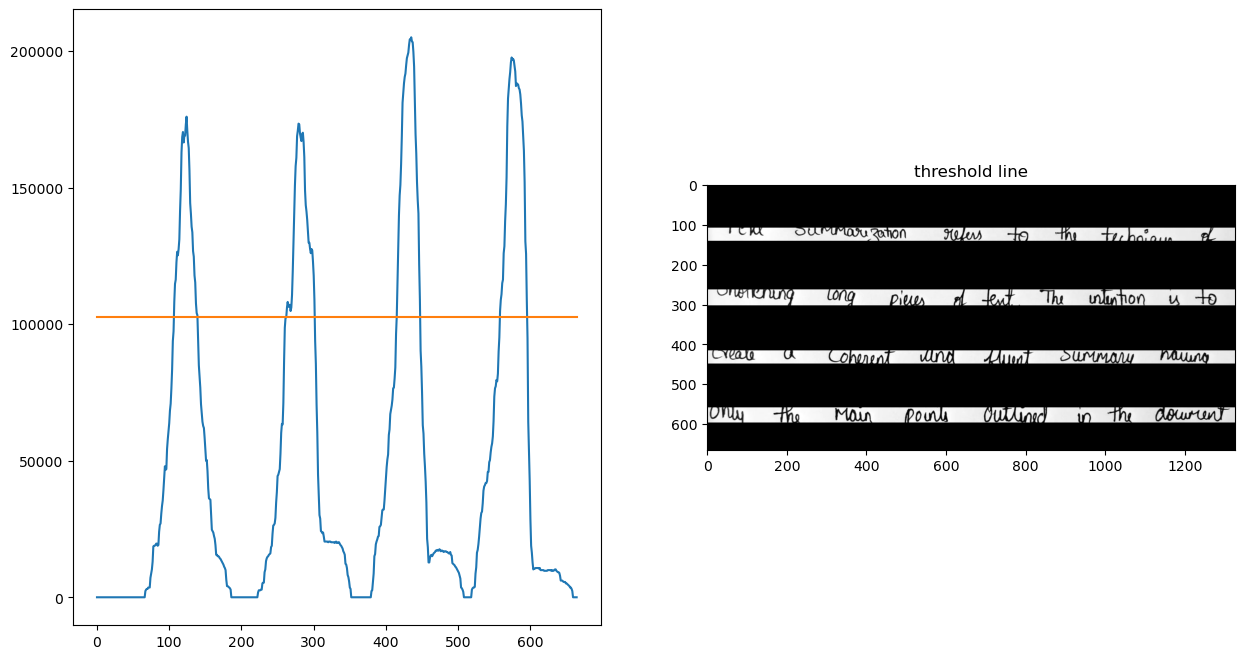

In [3]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):
    
    peaks = []
    for i, hppv in enumerate(hpp):
        if hppv < threshold:
            peaks.append([i, hppv])
    return peaks

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research. This may or may not work on all images.
threshold = (np.max(hpp)-np.min(hpp))/2
peaks = find_peak_regions(hpp, threshold)

peaks_indexes = np.array(peaks)[:, 0].astype(int)

segmented_img = np.copy(img)
r, c = segmented_img.shape
for ri in range(r):
    if ri in peaks_indexes:
        segmented_img[ri, :] = 0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.plot(hpp)
ax2.set_title("threshold line")
ax1.plot([0, img.shape[0]], [threshold, threshold,])
ax2.imshow(segmented_img, cmap="gray")
plt.show()


In [4]:
# group the peaks through which we will be doing path planning.
diff_between_consec_numbers = np.diff(peaks_indexes) # difference between consecutive numbers
indexes_with_larger_diff = np.where(diff_between_consec_numbers > 1)[0].flatten()
peak_groups = np.split(peaks_indexes, indexes_with_larger_diff)
# remove very small regions, these are basically errors in algorithm because of our threshold value
peak_groups = [item for item in peak_groups if len(item) > 1]
print("peak groups found", len(peak_groups))

peak groups found 5


In [5]:
#a star path planning algorithm 
from heapq import *

def heuristic(a, b):
    return (b[0] - a[0]) ** 2 + (b[1] - a[1]) ** 2

def astar(array, start, goal):

    neighbors = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    close_set = set()
    came_from = {}
    gscore = {start:0}
    fscore = {start:heuristic(start, goal)}
    oheap = []

    heappush(oheap, (fscore[start], start))
    
    while oheap:

        current = heappop(oheap)[1]

        if current == goal:
            data = []
            while current in came_from:
                data.append(current)
                current = came_from[current]
            return data

        close_set.add(current)
        for i, j in neighbors:
            neighbor = current[0] + i, current[1] + j            
            tentative_g_score = gscore[current] + heuristic(current, neighbor)
            if 0 <= neighbor[0] < array.shape[0]:
                if 0 <= neighbor[1] < array.shape[1]:                
                    if array[neighbor[0]][neighbor[1]] == 1:
                        continue
                else:
                    # array bound y walls
                    continue
            else:
                # array bound x walls
                continue
                
            if neighbor in close_set and tentative_g_score >= gscore.get(neighbor, 0):
                continue
                
            if  tentative_g_score < gscore.get(neighbor, 0) or neighbor not in [i[1]for i in oheap]:
                came_from[neighbor] = current
                gscore[neighbor] = tentative_g_score
                fscore[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heappush(oheap, (fscore[neighbor], neighbor))
                
    return []

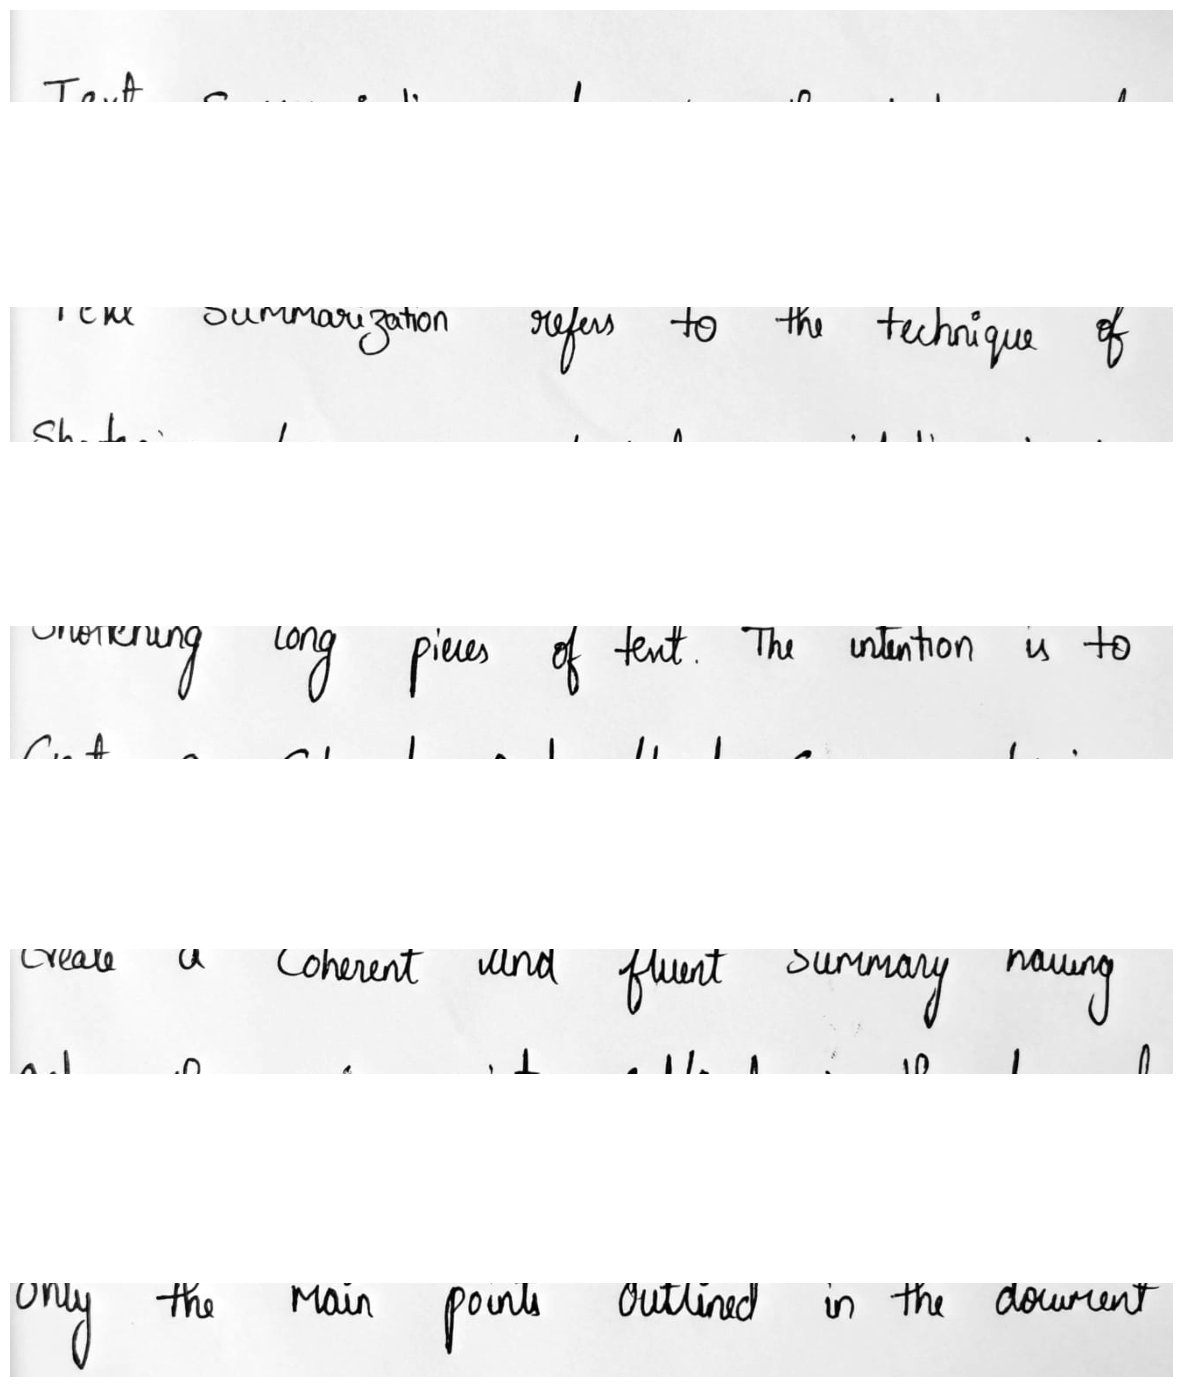

In [6]:
# Visualize the peak images
fig, ax = plt.subplots(nrows=len(peak_groups), ncols=1, figsize=(15,20))
for index, sub_image_index in enumerate(peak_groups):
    sub_image = img[sub_image_index[0]:sub_image_index[-1]]
    ax[index].axis("off")
    ax[index].imshow(sub_image, cmap="gray")
plt.show()

In [7]:
def get_binary(img):
    mean = np.mean(img)
    if mean == 0.0 or mean == 1.0:
        return img

    thresh = threshold_otsu(img)
    binary = img <= thresh
    binary = binary * 1
    return binary

binary_image = get_binary(img)
segment_separating_lines = []
for i, sub_image_index in enumerate(peak_groups):
    nmap = binary_image[sub_image_index[0]:sub_image_index[-1]]
    path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
    offset_from_top = sub_image_index[0]
    path[:,0] += offset_from_top
    segment_separating_lines.append(path)

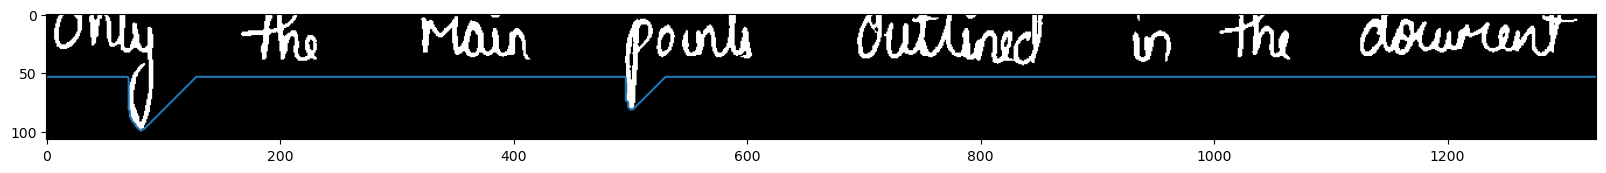

In [8]:
# visualize a sample
cluster_of_interest = peak_groups[-1]
offset_from_top = cluster_of_interest[0]
nmap = binary_image[cluster_of_interest[0]:cluster_of_interest[-1],:]
plt.figure(figsize=(20,20))
plt.imshow(nmap, cmap="gray")

path = np.array(astar(nmap, (int(nmap.shape[0]/2), 0), (int(nmap.shape[0]/2),nmap.shape[1]-1)))
plt.plot(path[:,1], path[:,0])

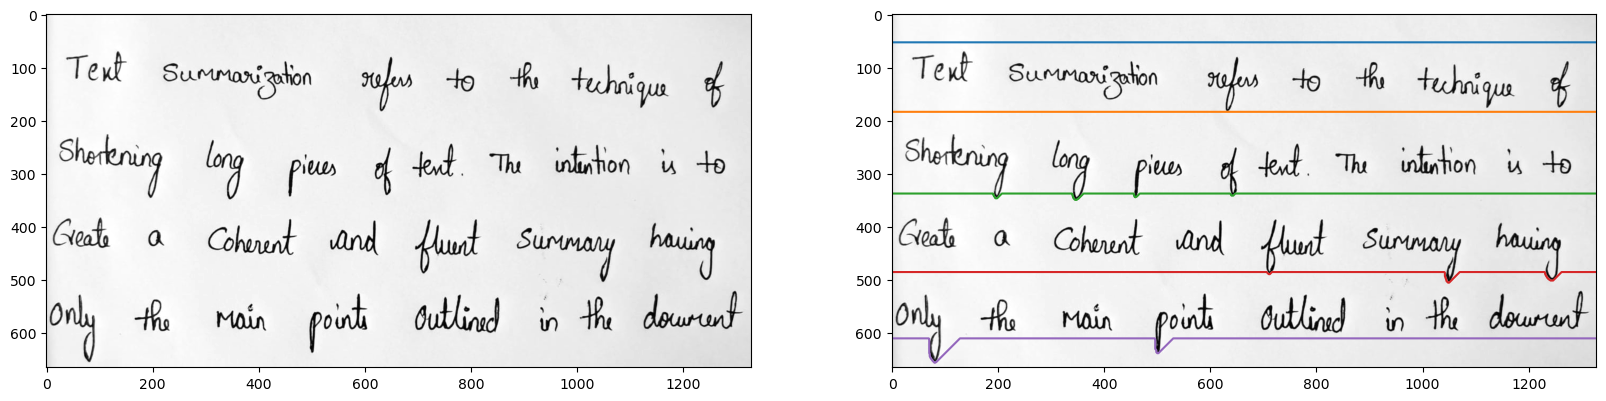

In [9]:
offset_from_top = cluster_of_interest[0]
fig, ax = plt.subplots(figsize=(20,10), ncols=2)
for path in segment_separating_lines:
    ax[1].plot((path[:,1]), path[:,0])
ax[1].imshow(img, cmap="gray")
ax[0].imshow(img, cmap="gray")

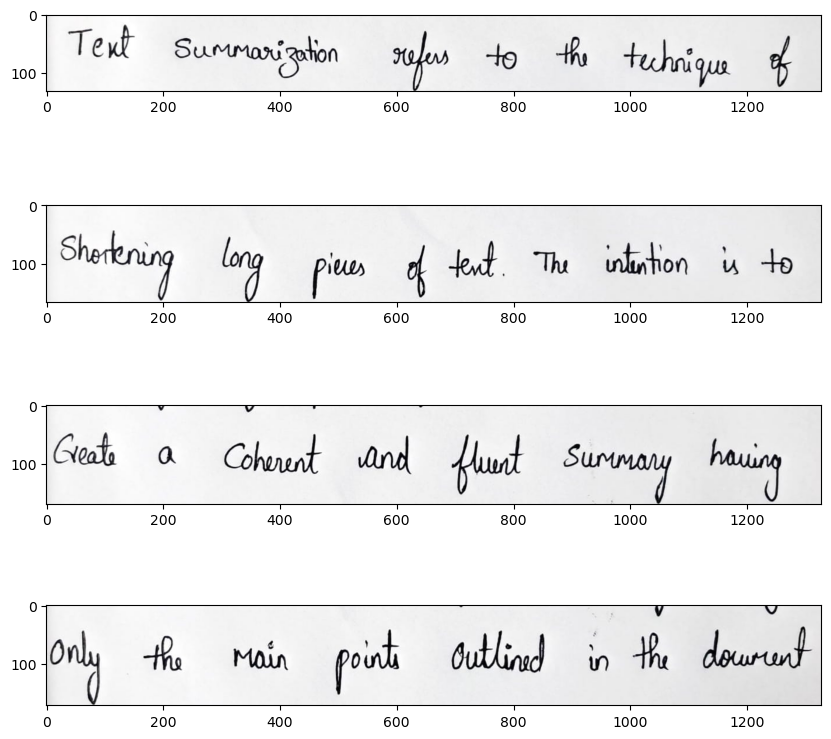

In [10]:
# TODO: the below splitting image algorithm is too simple
# I need to write a cleaner one.

seperated_images = []
for index, line_segments in enumerate(segment_separating_lines):
    if index < len(segment_separating_lines)-1:
        lower_line = np.min(segment_separating_lines[index][:,0])
        upper_line = np.max(segment_separating_lines[index+1][:,0])
        seperated_images.append(original_img[lower_line:upper_line])

# visualize it
fig, ax = plt.subplots(figsize=(10,10), nrows=len(seperated_images))
for index, line_image in enumerate(seperated_images):
    ax[index].imshow(line_image, cmap="gray")

plt.show()

In [30]:
import transformers
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
processor = TrOCRProcessor.from_pretrained('ocr_processor')
model = VisionEncoderDecoderModel.from_pretrained('ocr_model')

C:\Users\ADITYA D\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\ADITYA D\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [12]:
text=""
for index, line_image in enumerate(seperated_images):
    pixel_values = processor(images=line_image, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    text=text+" "+generated_text

C:\Users\ADITYA D\anaconda3\Lib\site-packages\transformers\generation\utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [13]:
text

' Text summarization refers to the technique of Shortening long pieces of text. The intention is to Grate a Coherent and fluent summary having only the main points outlined in the document'

In [14]:
from transformers import pipeline
summarizer=pipeline("summarization",model="text_summarizer")

C:\Users\ADITYA D\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [18]:
summary = summarizer(text,max_length=12)
summary[0]['summary_text']

'Text summarization refers to the technique of Shortening'